<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  FINAL PROJECT – Intelligient Data Analysis
</div>

| Name              | ID       |
|-------------------|----------|
| Trương Công Gia Phát |21127667|


## Import neccessary libraries

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

## 1. Data discovery

### **train.csv discovery**

In [9]:
dataset_df = pd.read_csv('train.csv')
dataset_df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4


### How many rows and how many columns?

In [10]:
print(f"The data has {dataset_df.shape[0]} rows and {dataset_df.shape[1]} columns.")

The data has 26296946 rows and 20 columns.


### Are there duplicated rows?

In [11]:
index = dataset_df.index
detectDupSeries = index.duplicated(keep='first')
num_duplicated_rows = detectDupSeries.sum()

if num_duplicated_rows == 0:
    print(f"Data have no duplicated line.!")
else:
    if num_duplicated_rows > 1:
        ext = "lines"
    else:
        ext = "line"
    print(f"Data have {num_duplicated_rows} duplicated " + ext + ". Please de-deduplicate your raw data.!")

Data have no duplicated line.!


### What is the meaning of each column?

In [12]:
col_meaning_df = pd.read_csv('data_schema.csv',  usecols=[0, 1])
pd.set_option('display.max_colwidth', 350)
col_meaning_df

,session_id,the ID of the session the event took place in
0,index,the index of the event for the session
1,elapsed_time,how much time has passed (in milliseconds) between the start of the session and when the event was recorded
2,event_name,the name of the event type
3,name,the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
4,level,what level of the game the event occurred in (0 to 22)
5,page,the page number of the event (only for notebook-related events)
6,room_coor_x,the coordinates of the click in reference to the in-game room (only for click events)
7,room_coor_y,the coordinates of the click in reference to the in-game room (only for click events)
8,screen_coor_x,the coordinates of the click in reference to the player’s screen (only for click events)
9,screen_coor_y,the coordinates of the click in reference to the player’s screen (only for click events)


### What is the current data type of each column? Are there columns having inappropriate data types?

In [13]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      int64  
 17  hq              int64  
 18  music           int64  
 19  level_group     object 
dtypes: float64(6), int64(7), object(7)
memory usage: 3.9+ GB


### With each numerical column, how are values distributed?

In [14]:
num_col_info_df = dataset_df.select_dtypes(exclude='object')
def missing_ratio(s):
    return (s.isna().mean() * 100).round(1)


num_col_info_df = num_col_info_df.agg([missing_ratio, "min", "max"])
num_col_info_df

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
missing_ratio,0.000000e+00,0.0,0.000000e+00,0.0,97.9,7.900000,7.900000,7.9,7.9,92.4,0.0,0.0,0.0
min,2.009031e+16,0.0,0.000000e+00,0.0,0.0,-1992.354569,-918.162349,0.0,0.0,0.0,0.0,0.0,0.0
max,2.210022e+16,20473.0,1.988607e+09,22.0,6.0,1261.773745,543.616424,1919.0,1440.0,245163690.0,1.0,1.0,1.0


### With each categorical column, what is the missing ratios?

In [15]:
cate_col_info_df = dataset_df.select_dtypes(include='object')
cate_col_info_df = cate_col_info_df.agg([missing_ratio])
cate_col_info_df

,event_name,name,text,fqid,room_fqid,text_fqid,level_group
missing_ratio,0.0,0.0,63.4,31.5,0.0,63.4,0.0


### What is the average elapsed time per level?

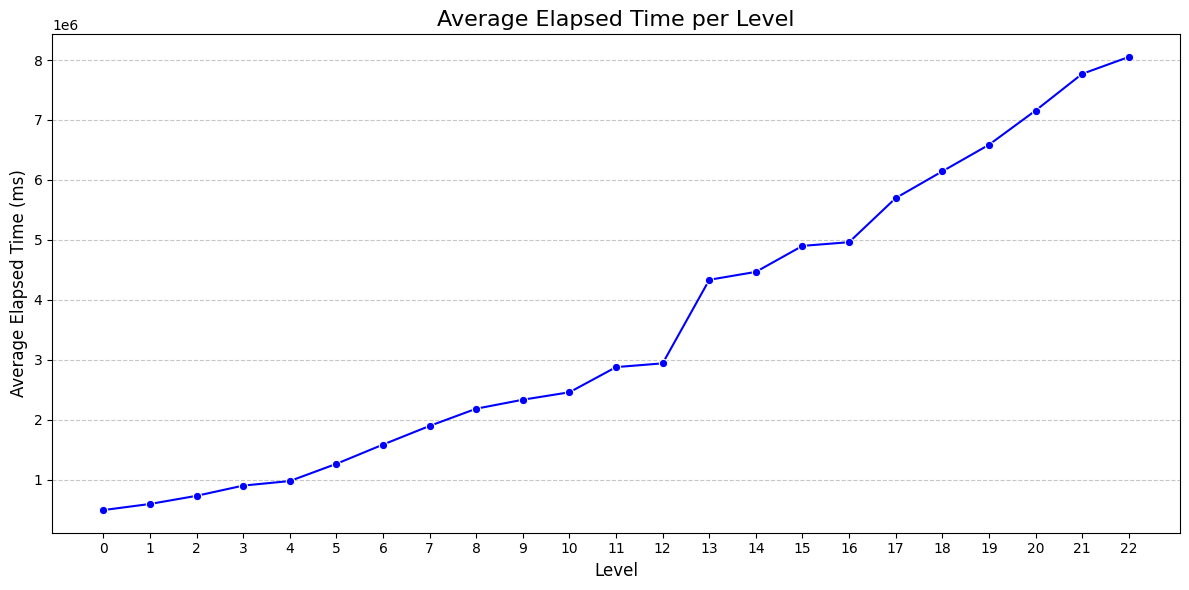

In [ ]:
dataset_df['elapsed_time'] = pd.to_numeric(dataset_df['elapsed_time'], errors='coerce')
dataset_df['level'] = pd.to_numeric(dataset_df['level'], errors='coerce')

average_time_per_level = dataset_df.groupby('level')['elapsed_time'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_time_per_level, x='level', y='elapsed_time', marker='o', color='blue')
plt.title("Average Elapsed Time per Level", fontsize=16)
plt.xlabel("Level", fontsize=12)
plt.ylabel("Average Elapsed Time (ms)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(average_time_per_level['level'])
plt.tight_layout()
plt.show()

--> We can see that the elapsed time increase when we reach higher level.

### What is the number of events per session in each level group?

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19940\3596952195.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=events_per_session, x='level_group', y='event_count', ci=None, estimator=sum, palette="Set2")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19940\3596952195.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=events_per_session, x='level_group', y='event_count', ci=None, estimator=sum, palette="Set2")


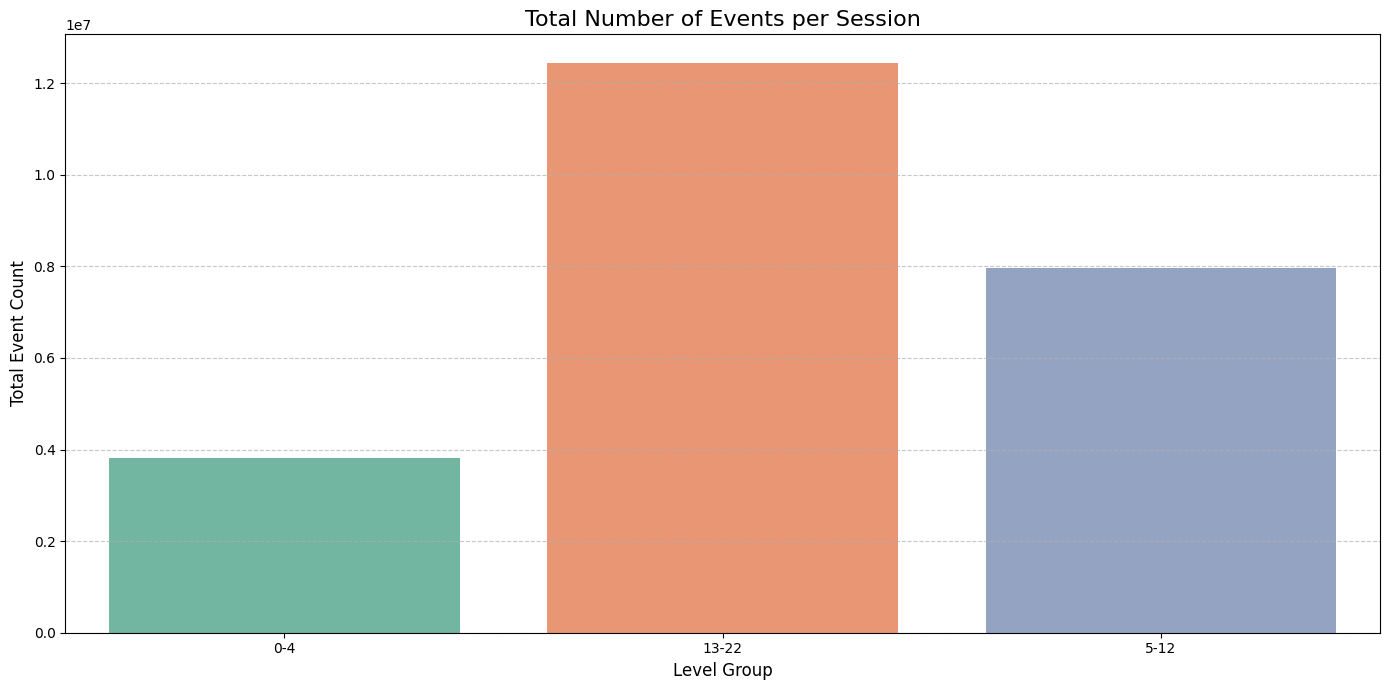

In [21]:
events_per_session = (
   dataset_df.groupby(['session_id', 'level_group'])
    .size()
    .reset_index(name='event_count')
)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=events_per_session, x='level_group', y='event_count', ci=None, estimator=sum, palette="Set2")
plt.title("Total Number of Events per Session", fontsize=16)
plt.xlabel("Level Group", fontsize=12)
plt.ylabel("Total Event Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--> The 13-22 has the most event out of 3 level groups, following it in second is 5-12 and last is 0-4.

### What are areas in the game rooms where clicks are concentrated?

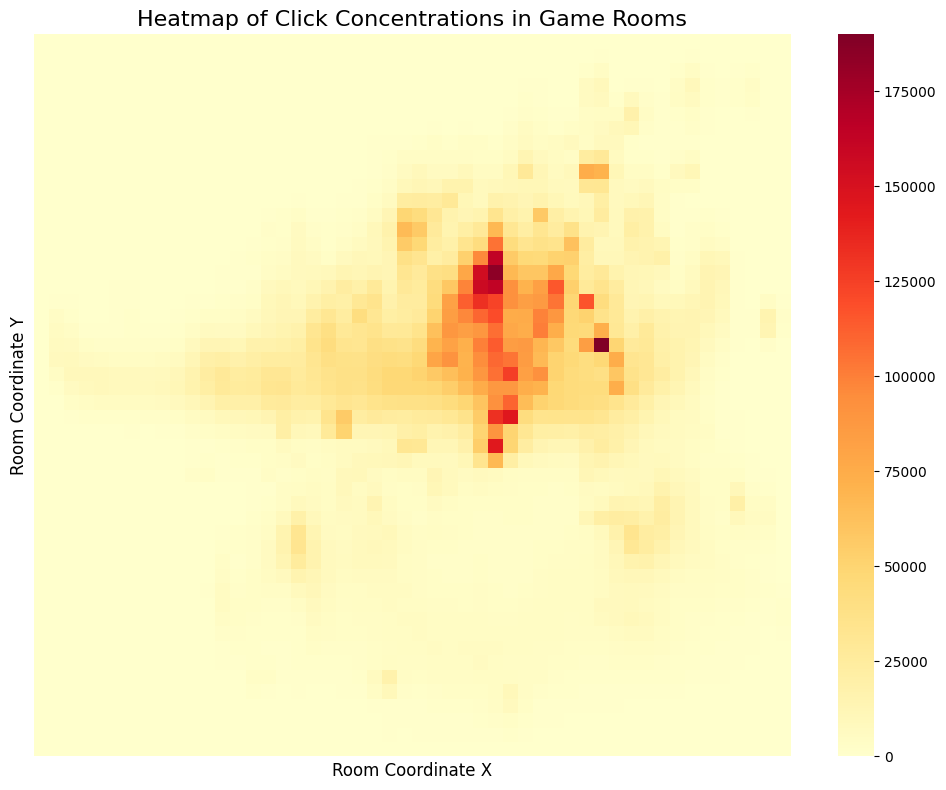

In [ ]:
clicks_df = dataset_df.dropna(subset=['room_coor_x', 'room_coor_y'])

heatmap_data, xedges, yedges = np.histogram2d(
    clicks_df['room_coor_x'], 
    clicks_df['room_coor_y'], 
    bins=[50, 50]  
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data.T, cmap="YlOrRd", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Heatmap of Click Concentrations in Game Rooms", fontsize=16)
plt.xlabel("Room Coordinate X", fontsize=12)
plt.ylabel("Room Coordinate Y", fontsize=12)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

--> The upper right middle is the section players clicked most.

### What are the proportions of players who use certain settings?

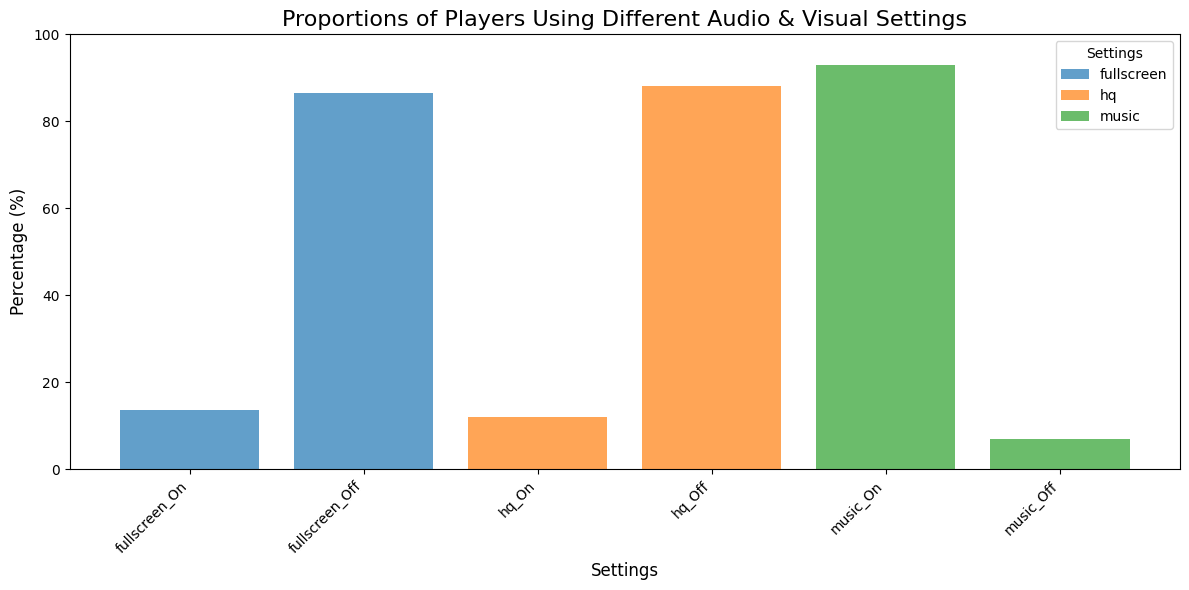

In [ ]:
settings = ['fullscreen', 'hq', 'music']
percentages = {setting: dataset_df[setting].value_counts(normalize=True) * 100 for setting in settings}

plt.figure(figsize=(12, 6))

for i, setting in enumerate(settings):
    plt.bar(
        x=[f"{setting}_On", f"{setting}_Off"],
        height=[percentages[setting].get(1, 0), percentages[setting].get(0, 0)],
        label=setting,
        alpha=0.7
    )

# Customize the plot
plt.title("Proportions of Players Using Different Audio & Visual Settings", fontsize=16)
plt.xlabel("Settings", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.legend(title="Settings", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)
plt.tight_layout()

plt.show()

--> We can see that most of the players play with fullscreen off, high quality off and music on.

### The percentage of players play with fullscreen

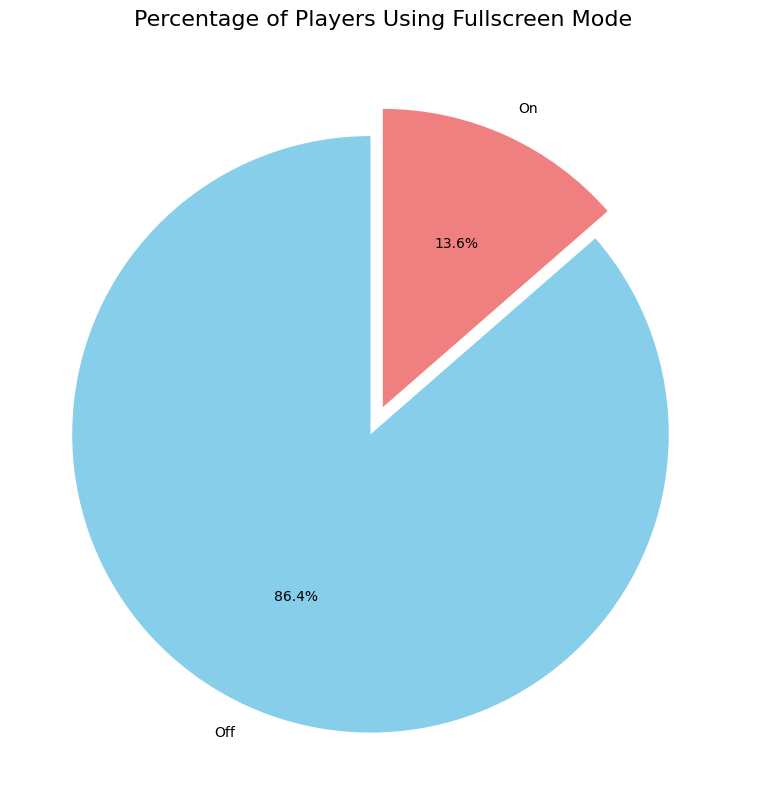

In [ ]:
fullscreen_percentages = dataset_df['fullscreen'].value_counts(normalize=True) * 100

# Pie chart for fullscreen mode
plt.figure(figsize=(8, 8))
plt.pie(
    fullscreen_percentages,
    labels=["Off", "On"],
    autopct="%1.1f%%",
    colors=["skyblue", "lightcoral"],
    startangle=90,
    explode=(0.1, 0)  # Slightly separate the "On" slice
)

plt.title("Percentage of Players Using Fullscreen Mode", fontsize=16)
plt.tight_layout()

plt.show()

--> We can see that to be more specific, 86.4% of players have their fullscreen off.

### **train_labels.csv discovery**

In [26]:
labels = pd.read_csv("train_labels.csv")
labels.head(5)

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


### How many rows and how many columns?

In [27]:
print(f"The data has {labels.shape[0]} rows and {labels.shape[1]} columns.")

The data has 424116 rows and 2 columns.


### Are there duplicated rows?

In [28]:
index = labels.index
detectDupSeries = index.duplicated(keep='first')
num_duplicated_rows = detectDupSeries.sum()

if num_duplicated_rows == 0:
    print(f"Data have no duplicated line.!")
else:
    if num_duplicated_rows > 1:
        ext = "lines"
    else:
        ext = "line"
    print(f"Data have {num_duplicated_rows} duplicated " + ext + ". Please de-deduplicate your raw data.!")

Data have no duplicated line.!


### The "correct" column values for 18 questions

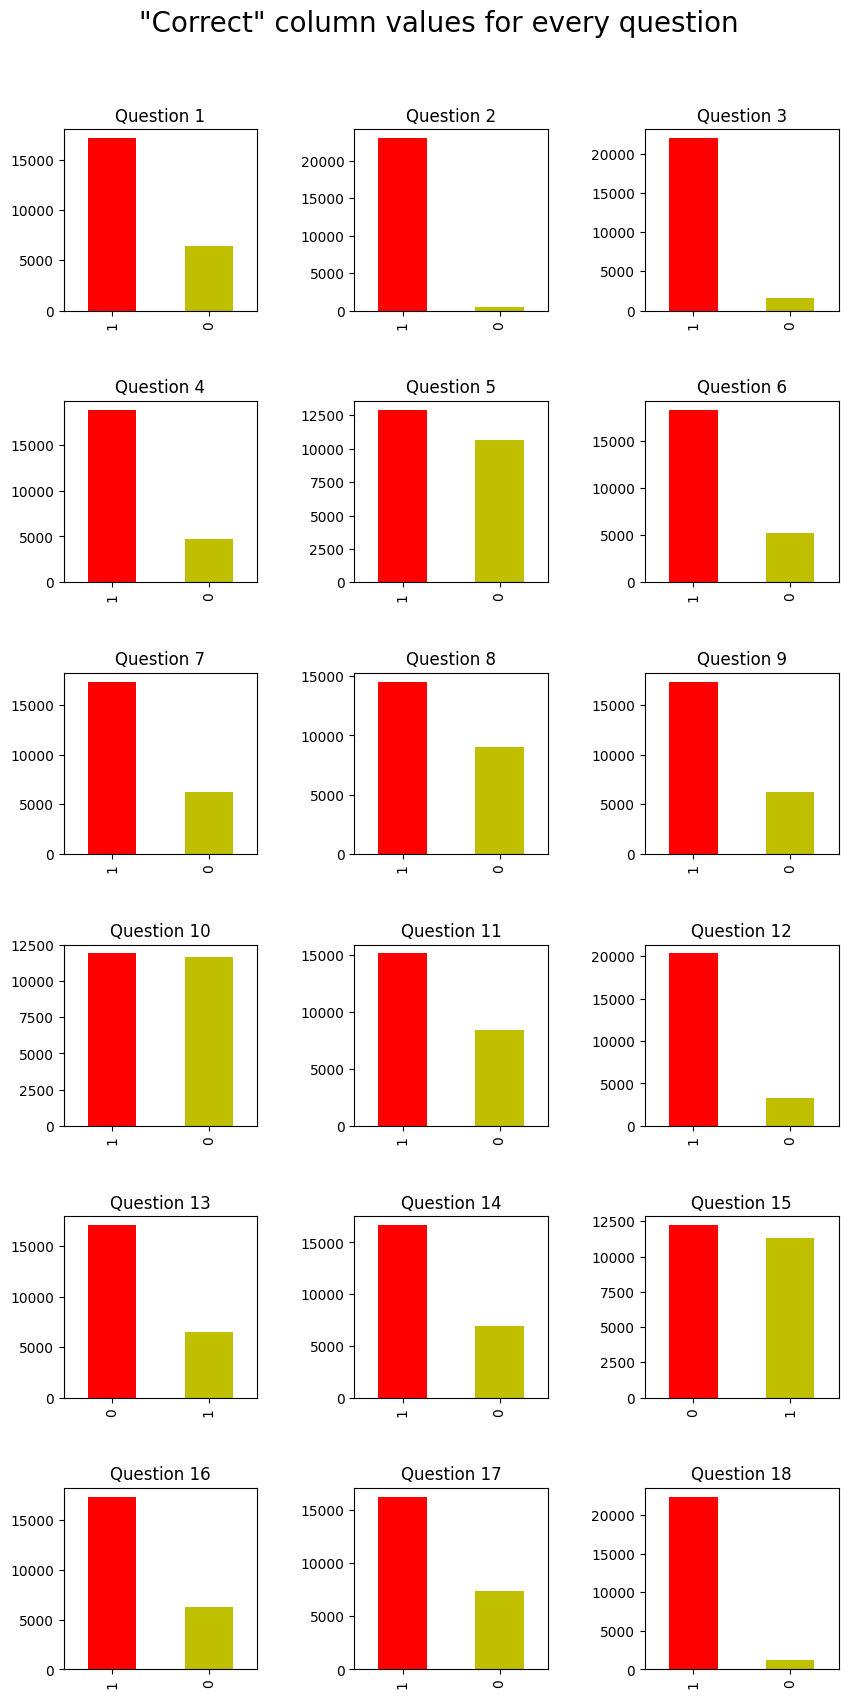

In [ ]:
labels = pd.read_csv("train_labels.csv")
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for every question", fontsize=20, y=0.94)
for n in range(1,19):
    ax = plt.subplot(6, 3, n)

    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['r', 'y'])

    ax.set_title("Question " + str(n))
    ax.set_xlabel("")

--> Each of the bar chart shows the distribution of correct values (0/1) for a specific question in your dataset.

## 2. Data Preprocessing

We convert the data type of each column based on the defined dtypes to make it easier for the later process

In [4]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category',
    }

dataset_df = pd.read_csv('train.csv', dtype=dtypes)

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      category
 17  hq              category
 18  music           category
 19  level_group     category
dtypes: category(10), float32(5), float64(1), int32(1), int64(2), uint8(1)
memory usage: 1.5 GB


For the labels dataset, we will add other 2 columns by splitting the value in column session_id. 

In [3]:
labels = pd.read_csv("train_labels.csv")
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


## 3. Feature Engineering

Firstly, we will identify categorical and numerical columns.

In [5]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

Next, we will perform feature engineering by aggregating categorical and numerical features at the session-level grouped by level_group.

In [ ]:
def feature_engineer(dataset_df):

    agg_results = []
    for col in CATEGORICAL:
        agg = dataset_df.groupby(['session_id', 'level_group'], observed=True)[col].nunique()
        agg.name = f"{col}_nunique"
        agg_results.append(agg)

    for col in NUMERICAL:
        mean_agg = dataset_df.groupby(['session_id', 'level_group'], observed=True)[col].mean()
        mean_agg.name = f"{col}_mean"
        agg_results.append(mean_agg)
        
        std_agg = dataset_df.groupby(['session_id', 'level_group'], observed=True)[col].std()
        std_agg.name = f"{col}_std"
        agg_results.append(std_agg)

    features_df = pd.concat(agg_results, axis=1)
    features_df.fillna(-1, inplace=True)
    features_df.reset_index(inplace=True)

    features_df.set_index('session_id', inplace=True)
    
    return features_df

train_features = feature_engineer(dataset_df)

In [11]:
train_features.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time_mean,elapsed_time_std,level_mean,level_std,...,room_coor_x_mean,room_coor_x_std,room_coor_y_mean,room_coor_y_std,screen_coor_x_mean,screen_coor_x_std,screen_coor_y_mean,screen_coor_y_std,hover_duration_mean,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,49246.539458,1.945455,1.230975,...,7.701275,399.296051,-71.413750,129.292404,448.410248,214.871002,383.044861,104.082741,2389.500000,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,126666.129584,17.402381,2.358652,...,-130.347168,622.061401,-162.004303,230.370880,442.489807,240.280212,379.301025,99.067863,899.925903,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,80175.676658,8.054054,2.096919,...,14.306062,357.227692,-57.269321,137.409470,451.950958,203.268555,378.784912,120.255455,969.333313,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,67372.714092,1.870504,1.232616,...,-84.045959,445.980042,-53.671082,156.186249,358.223083,252.554703,370.723083,121.062927,1378.750000,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,777382.529186,17.762529,1.825923,...,-30.762283,529.575684,-142.861893,234.279587,462.852478,259.288849,387.930084,133.345688,720.384949,1990.705518


Now that we have a new dataset, we will split it based on the ratio of 80%, we will have 80% of the data for training and 20% for validating. After we splited, we will convert them to a csv file and upload it to Kaggle to build our model.

In [12]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(train_features)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

train_x.to_csv("train_x.csv")
valid_x.to_csv("valid_x.csv")

56547 examples in training, 14139 examples in testing.
